<a href="https://colab.research.google.com/github/lauratomokiyo/imspeaking/blob/main/EdTechProject_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ed Tech Project - Laura Tomokiyo
## Instructions

To run this notebook, you will run each code block independently.  

Sometimes, code blocks are clustered, and you will see a bent arrow and text like "3 cells hidden."  If you mouse over the box at the left of that line, you will see an arrow.  Cick that and wait for the run to complete.  The line around the box will stop spinning when it is complete.

Sometimes, you might see some lines of code in a block.  There should be a box made of square brackets at the left of the block.  If you mouse over it, there should be an arrow.  Click the arrow and wait for completion. For these individual (not clustered) blocks, you will see a green check mark when it is complete.

Some of the blocks take some time to run, and you will see some output messages.  If you get something like "error" at the end, or get a red mark instead of a green check mark, it means that there is a problem with the code.  Please let me know so I can fix it.  Otherwise, you can ignore the messages, but wait for the check mark before you scroll down to the next block.

## Initial Setup


In [1]:
# Initial imports and installs
!sudo apt install ffmpeg
!pip install torchaudio -q
!pip install ipywebrtc -q
!pip install notebook -q
#!pip install ipywebrtc --upgrade
#!jupyter nbextension enable --py widgetsnbextension
!pip install praatio -q
!pip install montreal-forced-aligner -q

import os
import zipfile
from datetime import datetime
import subprocess
import gc


from ipywebrtc import AudioRecorder, CameraStream
import scipy
from IPython.display import Audio, display,HTML

from google.colab import output
output.enable_custom_widget_manager()

import ipywidgets as widgets
import matplotlib.pyplot as plt
import scipy.io.wavfile
import librosa
import numpy as np
import soundfile as sf
from praatio import textgrid
import re

!pip install pyfiglet
import pyfiglet

mode = 'live' # offline or live

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.5/406.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.5 MB/s eta 0:00:00


In [2]:
### Session Setup

GENDER='male'
userid = 'flt000'
user_favorites = [0]*10
import gc

In [3]:
prompts = [
  "I'd like to make an appointment.",
  "Can I change my flight return date?",
  "I'd like the blue cheese burger with bacon.",
  "How can I get to the train station?",
  "That's a difficult situation.",
  "Could we get the check, please?",
  "Does this bus go to the airport?",
  "You could ask him.",
  "Is it okay if I join you?",
  "Tariffs are paid by the consumer."
]

##MFA Setup

This section sets up the Montreal Forced Aligner.  It takes some time to load and run.  The forced aligner is used to find the boundaries between words and phonemes in the speech signal.

Credit https://gist.github.com/NTT123/12264d15afad861cb897f7a20a01762e

Credit https://eleanorchodroff.com/tutorial/montreal-forced-aligner.html

In [4]:
# MFA setup

%%writefile install_mfa.sh
#!/bin/bash

## a script to install Montreal Forced Aligner (MFA)

root_dir=${1:-/tmp/mfa}
mkdir -p $root_dir
cd $root_dir

# download miniconda3
wget -q --show-progress https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh -b -p $root_dir/miniconda3 -f

$root_dir/miniconda3/bin/conda create -n aligner -c conda-forge montreal-forced-aligner -yq

source $root_dir/miniconda3/bin/activate aligner

# install mfa, download kaldi
#pip install montreal-forced-aligner -q

# this one works without Kaldi
pip install git+https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner.git -q # install latest updates

conda install -yq pytorch torchvision torchaudio cpuonly -c pytorch

#mfa thirdparty download
#mfa download

echo -e "\n======== DONE =========="




Writing install_mfa.sh


In [5]:
# download and install mfa
INSTALL_DIR="/tmp/mfa" # path to install directory

# make sure the environment and dependencies are right for MFA
!bash ./install_mfa.sh {INSTALL_DIR}
!source {INSTALL_DIR}/miniconda3/bin/activate aligner#; mfa align --help

# install sox tool
!sudo apt install -q -y sox

# download an english acoustic model (needs to be downloaded because we're in a colab?)
!wget -q --show-progress https://github.com/MontrealCorpusTools/mfa-models/raw/main/acoustic/english.zip


Miniconda3-latest-L 100%[===================>] 141.46M  97.5MB/s    in 1.5s    
PREFIX=/tmp/mfa/miniconda3
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /tmp/mfa/miniconda3
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /tmp/mfa/miniconda3/envs/aligner

  added / updated specs:
    - montreal-forced-aligner


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mute

In [6]:
# Get audio files
# these are the reference files that have been pre-recorded, and also pre-recorded learner files for debugging

#!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/r4.zip
!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/rft4.zip
!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/rmt4.zip
!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/fyi.zip
!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/promptlex.txt
!unzip -qq /content/rft4.zip  # female reference
!unzip -qq /content/rmt4.zip # male reference
!unzip -qq /content/fyi.zip # female learner

reffiledir = "/content/reference_audio_female_trimmed/"
learnerfiledir = "/content/learner_baseline_audio/"

if mode == 'offline':
  !wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/f.zip
  !unzip -qq /content/f.zip

tempalignmentdir = '/content/mfa/'



In [7]:
#!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/mkt.zip
#!unzip -qq /content/mkt.zip  # male learner

### Support functions for plotting


In [8]:
# Display pitch contours and duration information

def get_duration_statistics(tier):
  vowel_count = 0
  vowel_duration = 0
  for (start,stop,word) in tier.entries:
    if any(digit in word for digit in ['0','1','2']):
      vowel_count += 1
      vowel_duration += (stop-start)

  nwords = len(tier)
  utt_start = tier.entries[0][0]
  utt_end = tier.entries[-1][1]
  speaking_duration = utt_end-utt_start
  speaking_rate = nwords/speaking_duration
  ave_vowel_dur = vowel_duration / vowel_count
#  print(f'there is {speaking_duration} total speaking time and {nwords} phonemes')
  return(speaking_rate,ave_vowel_dur)

def trim_clicks(audiofile):
  # assume hop_length = 512
  # click is about 0.05s
  trim_dur = 512*3
  return(audiofile[trim_dur:-trim_dur])

def trim_silence(audiofile):
  trimmed,index = librosa.effects.trim(audiofile,top_db=20)
  # add a small amount of silence back for naturalness
  buffer_length = 10*512 # 10 frames * 512 hop length
  buffer_length = 2*512 # 10 frames * 512 hop length
  start_index = max(0,index[0] - buffer_length)
  end_index = min(index[1] + buffer_length, len(audiofile))
  audio_with_buffer = audiofile[start_index:end_index]
  return(audio_with_buffer)


### Enable file saving

In [9]:
save_dir = '/content/saved_files'
os.makedirs(save_dir, exist_ok=True)
sample_rate=44100


def save_audio(idx,trial):
  filename = f"recording_{userid}_{idx}_{trial}.wav"
  destination_path = os.path.join(save_dir,filename)
  sourcefile = f'f{idx}.wav'
  !cp {sourcefile} {destination_path}

# save_audio(1,0) # saves file /content/saved_files/recording_fyi001_1_0.wav

def zip_audio_files():
    zip_path = "/content/saved_recordings.zip"
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for root, _, files in os.walk(save_dir):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=file)
    print(f"All files zipped at {zip_path}")

#save_button = widgets.Button(description="Save Audio to Folder")
#def on_save_click(b):
#    save_audio(1,2)
#save_button.on_click(on_save_click)

### Query favorite audio

In [10]:
# Function to query favorite audio
def query_favorite(prompt_idx):
    print('Which one is your favorite?')
    audio_widgets = []
    for trial in [1, 2, 3]:
        filename = f"recording_{userid}_{prompt_idx}_{trial}.wav"
        destination_path = os.path.join(save_dir, filename)
        y, sr = librosa.load(destination_path)

        # Create audio player HTML
        audio = Audio(y, rate=sr, autoplay=False)
        audio_widget = widgets.HTML(value=audio._repr_html_())  # Convert to HTML
        label = widgets.Label(value=f'Audio {trial}')

        # Place audio player and label side-by-side
        hbox = widgets.HBox([audio_widget, label])
        audio_widgets.append(hbox)

    # Display each audio player and label HBox
    for hbox in audio_widgets:
        display(hbox)

    # Create and display radio buttons
    radio_buttons = widgets.RadioButtons(
        options=[(f"Audio {i}", i) for i in range(1, 4)],
        description='Favorite:',
        disabled=False
    )
    display(radio_buttons)

    # Button to confirm selection
    confirm_button = widgets.Button(description="Confirm Selection", button_style='success')

    # Function to handle button click and print selected choice
    def on_confirm_click(b):
        print(f"You selected Audio {radio_buttons.value} as your favorite.")
        user_favorites[prompt_idx-1] = radio_buttons.value

    confirm_button.on_click(on_confirm_click)
    display(confirm_button)


### Main plotting function


In [11]:
def plot_contours(idx,mode='live',gender=None,direct_filename='',run_mfa=True):

  gender = gender if gender is not None else GENDER

  if gender=='male':
    reffiledir = "/content/reference_audio_male_trimmed/"
  else:
    reffiledir = "/content/reference_audio_female_trimmed/"

  #########################
  ####### LOAD AUDIO ######
  ref_file = f'{reffiledir}r{idx}.wav'
  learner_file = f'f{idx}.wav'
  print(f'learner file is {learner_file}')

  # write file if needed and load audio
  if mode == 'live':
    y_l,sr_l = librosa.load(learner_file)
    y_trimmed = trim_silence(trim_clicks(y_l))

  elif mode == 'offline':
    print(f'Prompt is: {prompts[idx-1]}')
    y_l,sr_l = librosa.load(f'{learnerfiledir}f{idx}.wav')
    y_trimmed = trim_silence(y_l)

  elif mode == 'direct':
    y_l,sr_l = librosa.load(direct_filename)
    y_trimmed = trim_silence(y_l)

  else:
    print('unknown mode')

  # load reference audio files
  y_r,sr_r = librosa.load(ref_file)

  # get duration information from learner and reference
  dur1 = librosa.get_duration(y=y_trimmed,sr=sr_l)
  dur2 = librosa.get_duration(y=y_r,sr=sr_r)
  dur_max = max(dur1,dur2)


  #################################################
  ###### SET UP TEMPORARY WORK SPACE FOR MFA ######
  # make temporary directory for alignments
  !rm -rf /content/mfa/
  !mkdir -p /content/mfa/sourcefiles/
  !mkdir -p /content/mfa/aligned/

  # copy of single wav/text file pair to temporary directory
  learner_wave_file = f"{tempalignmentdir}sourcefiles/f{idx}.wav"
  learner_text_file = f"{tempalignmentdir}sourcefiles/f{idx}.txt"

  # write temporary copy of learner wave file to alignment directory
  # write prompt text file to learner file dir
  with open (learner_text_file,'w') as f:
    f.write(prompts[idx-1])
  sf.write(learner_wave_file, y_trimmed, sr_l)

  ###########################
  ###### PLOT WAVEFORM ######
  plt.figure(figsize=(10, 3))
  librosa.display.waveshow(y_trimmed, sr=sr_l, alpha=0.5)
  xlabel_text = f'Time (s)'

  ############################
  ###### GET ALIGNMENTS ######
  # this is SUPER slow, even with minimal lexicon
  if run_mfa:
    !source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa align --clean -j 1 /content/mfa/sourcefiles promptlex.txt english.zip /content/mfa/aligned

    ### From ChatGPT.  I didn't know how to do a try/except on a bash command within a colab cell.
    import subprocess  # LT causes an error if you don't keep the import in this function.

    try:
        # Run the command using subprocess.run, which provides better error handling
      result = subprocess.run(
          f"source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa align --clean -j 1 /content/mfa/sourcefiles promptlex.txt english.zip /content/mfa/aligned",
          shell=True,  # Needed for using shell commands in a single string #LT might cause conflicts with multiple shells?
          check=True,  # Raises an exception if the command fails
          executable='/bin/bash',  # Ensures compatibility with 'source' and 'activate'
          stdout=subprocess.PIPE,  # Capture standard output
          stderr=subprocess.PIPE   # Capture error output
      )

      # Print output if needed
      # print(f"TRY RESULT: {result.stdout.decode()}")  # Decodes byte output to string for readability

    except subprocess.CalledProcessError as e:
      print("An error occurred while running the command.")
      print("Error message:", e.stderr.decode())  # Display the error message from stderr
      alignment_successful=False
    ### ENd ChatGPT

    else:
      alignment_successful=True

    if alignment_successful:
      tg = textgrid.openTextgrid(f'/content/mfa/aligned/f{idx}.TextGrid',includeEmptyIntervals=False)
      textgrid_entries = tg.getTier('phones') # tg.getTier('words')
      (spk_rate,vowel_len) = get_duration_statistics(textgrid_entries)
      print(f'phone sequence is {[p for (s,e,p) in textgrid_entries]}')

      # set up plot elements for alignment (red lines, phone labels, time values)
      for start, end, word in textgrid_entries:
        word = re.sub('_[BEIS]','',word)
        plt.axvspan(start, end, color='lightgray', alpha=0.5)  # Highlight the word region
        plt.text((start + end) / 2, -0.1, word, horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')
        plt.axvline(start,color='r',linestyle='--',alpha=0.15)
        plt.axvline(end,color='r',linestyle='--',alpha=0.15)
        xlabel_text = f'Time (s) - Learner speaking rate {spk_rate:.2f} phonemes/second and average vowel length {vowel_len:.2f} seconds'


  # complete plot
  plt.xlim(0,dur_max)
  if run_mfa:
    plt.xlabel(f'Time (s) - Learner speaking rate {spk_rate:.2f} phonemes/second and average vowel length {vowel_len:.2f} seconds')
  else:
    plt.xlabel(f'Time (s)')

  plt.xlabel(xlabel_text)
  plt.ylabel('Amplitude')
  plt.show()

  #######################################
  ###### PITCH EXTRACTION (PEPLOs) ######
  # average male: 120: average female: 220
  f0, voiced_flag, voiced_probs = librosa.pyin(y_trimmed, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')) # trimmed recording
  f0_ref, vf_ref, vp_ref = librosa.pyin(y_r, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')) # reference recording

  # get utterance lengths to assign plot size (x limit)
  time1 = librosa.frames_to_time(np.arange(len(f0)), sr=sr_l) # trimmed
  time2 = librosa.frames_to_time(np.arange(len(f0_ref)), sr=sr_r) # reference

  ###########################
  ###### PLOT CONTOURS ######
  plt.figure(figsize=(10, 3))
  plt.plot(time1, f0, color='b', label='learner')
  plt.plot(time2, f0_ref, color='g', label='reference')
  plt.xlabel('Time (s)')
  plt.ylabel('Frequency (Hz)')

  max_y_value = max(np.nanmax(f0), np.nanmax(f0_ref)) # find max value of ref and learner pitch
  plt.ylim(0, max_y_value + 50)  # Set y-axis to start at 0 Hz and go to max from above

  plt.title('Pitch Contour')
  plt.legend(loc='upper left', bbox_to_anchor=(1,1))
  plt.tight_layout()
  plt.show()

  ###### PROVIDE LISTENING BUTTONS ######
  print("Click the button below to play the learner audio:")
  display(Audio(y_trimmed, rate=sr_l))
  print("Click the button below to play the reference audio:")
  display(Audio(y_r, rate=sr_r))

## Live Testing

Here is where you will record your voice.  There are 10 prompts.
 Each prompt has two sections, which you repeat 4 times.

Section 1: Record your voice
After you run this block, you will see a record button and a play button.  Click the record button once to record, and again to stop.  You will hear your recording immediately.  If you want to re-record it, just click to record and click to stop again.

Section 2: Check the analysis
You will see your voice waveform and its pitch contour, lined up against the pitch contour of a native speaker.  Are they close?  See if you can copy the pitch/intonation of the native speaker.  You can try it 3 different times.

At the end, you will be asked which of your recordings you liked the best.  It doesn't have to be the one that is closest to the native speaker.  Listen to all three, choose the one you like best, and click "confirm."

You will probably reach a point where the recording button stops working.  This is just a limitation of Google Colab.  If the button stays red even if you click to stop, go ahead and re-run that block so the recorder button loses the red dot.  Then, scroll to the bottom and run the block that says "End Session."

In [12]:
mode='live'
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)


### Prompt 1: I'd like to make an appointment.

#### Trial 1

In [13]:
recorder = AudioRecorder(stream=camera)
prompt_idx = 1
trial_idx = 0
print(f'Say the sentence "{prompts[0]}"')
display(recorder)

Say the sentence "I'd like to make an appointment."


AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

learner file is f1.wav


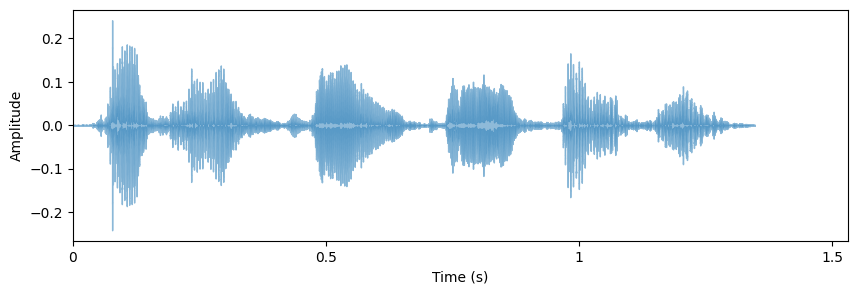

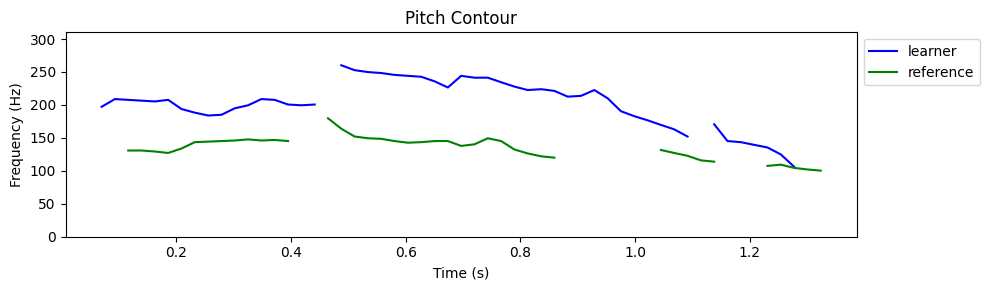

Click the button below to play the learner audio:


Click the button below to play the reference audio:


In [14]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav f1.wav -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
#plot_contours(1,mode='live',run_mfa=True)
# switch to the following line if you don't want to wait for the alignments
plot_contours(1,mode='live',run_mfa=False)

learner file is f1.wav
 INFO     Setting up corpus information...                                                          
 INFO     Loading corpus from source files...                                                       
   1% ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/100  [ 0:00:01 < -:--:-- , ? it/s ]
 INFO     Found 1 speaker across 1 file, average number of utterances per speaker: 1.0              
 INFO     Initializing multiprocessing jobs...                                                      
 INFO     Normalizing text...                                                                       
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1  [ 0:00:01 < 0:00:00 , ? it/s ]
 INFO     Generating MFCCs...                                                                       
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1  [ 0:00:16 < 0:00:00 , ? it/s ]
 INFO     Calculating CMVN...                                       

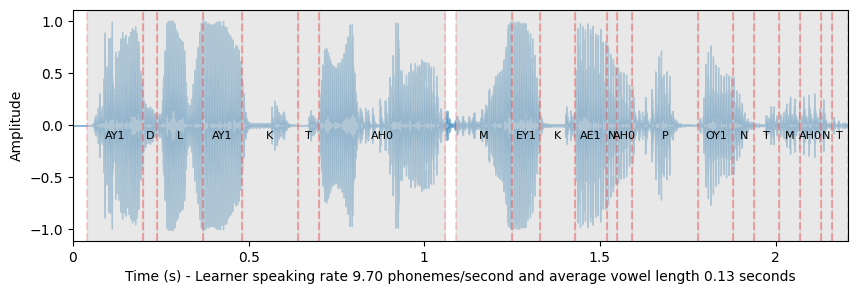

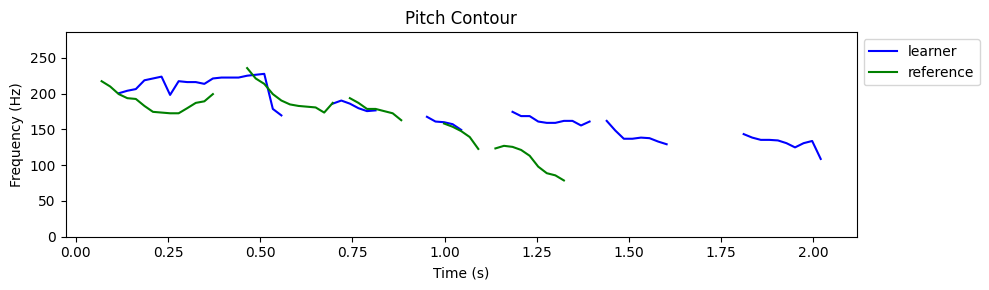

Click the button below to play the learner audio:


Click the button below to play the reference audio:


In [15]:
# tmp for demo
plot_contours(1,mode='direct', direct_filename='/content/saved_files/recording_fyi001_1_0.wav', gender='female', run_mfa=True)

#### Trial 2

In [ ]:
recorder = AudioRecorder(stream=camera)
trial_idx = 1
print(f'Say the sentence "{prompts[0]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav f1.wav -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(1,mode='live',run_mfa=True)

#### Trial 3

In [ ]:
recorder = AudioRecorder(stream=camera)
trial_idx = 2
print(f'Say the sentence "{prompts[0]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav f1.wav -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(1,mode='live',run_mfa=False)

#### Trial 4

In [ ]:
recorder = AudioRecorder(stream=camera)
trial_idx = 3
print(f'Say the sentence "{prompts[0]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav f1.wav -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(1,mode='live',run_mfa=False)

In [ ]:
query_favorite(prompt_idx)

### Prompt 2: Can I change the flight return date?

In [ ]:
del recorder
gc.collect()
recorder = AudioRecorder(stream=camera)
prompt_idx = 2
outwavfile = f"f{prompt_idx}.wav"
trial_idx = 0
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav f2.wav -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live')

In [ ]:
trial_idx = 1
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav f2.wav -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live')

In [ ]:
trial_idx = 2
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
trial_idx = 3
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
query_favorite(2)

### Prompt 3: I'd like the blue cheese burger with bacon.

In [ ]:
del recorder
gc.collect()
recorder = AudioRecorder(stream=camera)
prompt_idx = 3
outwavfile = f"f{prompt_idx}.wav"

trial_idx = 0
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live')

In [ ]:
trial_idx = 1
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
trial_idx = 2
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
trial_idx = 3
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
query_favorite(prompt_idx)

### Prompt 4: How can I get to the train station?

In [ ]:
del recorder
gc.collect()
recorder = AudioRecorder(stream=camera)
prompt_idx = 4
outwavfile = f"f{prompt_idx}.wav"

trial_idx = 0
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
trial_idx = 1
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
trial_idx = 2
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
trial_idx = 3
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
query_favorite(prompt_idx)

In [ ]:
%who

### Prompt 5

In [ ]:
del recorder
gc.collect()
recorder = AudioRecorder(stream=camera)
prompt_idx = 5
outwavfile = f"f{prompt_idx}.wav"

trial_idx = 0
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live')

In [ ]:
import time

camera.close()
del recorder
gc.collect()
time.sleep(1)  # Brief delay to ensure resources are freed
camera.active=True
camera = CameraStream(constraints={'audio': True,'video':False})  # Recreate CameraStream
recorder = AudioRecorder(stream=camera)
display(recorder)

In [ ]:
trial_idx = 1
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live')

In [ ]:
trial_idx = 2
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
trial_idx = 3
print(f'Say the sentence "{prompts[prompt_idx-1]}"')
display(recorder)

In [ ]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav {outwavfile} -y -hide_banner -loglevel panic
save_audio(prompt_idx,trial_idx)
plot_contours(prompt_idx,mode='live',run_mfa=False)

In [ ]:
query_favorite(prompt_idx)

## End Session

In [ ]:
faves = f'Favorites for user {userid} are: {user_favorites}'
print(faves)
filepath = os.path.join(save_dir,'favorites.txt')
with open (filepath,'w') as f:
  f.write(faves)
savefilename = f'saved_files_{userid}_{prompt_idx}.zip'
try:
  !zip -qr {savefilename} {save_dir}
  print(f'All files zipped to {savefilename}')
except Exception as e:
  print(f'An error occurred: {e}')

ascii_art = pyfiglet.figlet_format("Thank You", font="jazmine")
print(ascii_art)

# The End!
Don't worry about anything after this.  It is just for development.

## Offline Testing

In [ ]:
# Check any utterance, e.g. prompt 9
!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/f.zip
!unzip -qq /content/f.zip  # male learner
plot_contours(9,mode='offline')

## Direct Testing

In [ ]:
plot_contours(1,mode='direct', direct_filename='/content/saved_files/recording_fyi001_1_0.wav', gender='female', run_mfa=True)

## Batch Testing

In [ ]:
# Batch testing
!wget -q https://raw.githubusercontent.com/lauratomokiyo/imspeaking/main/mkt.zip
!unzip -qq /content/mkt.zip  # male learner

In [ ]:
from scipy.interpolate import interp1d
from librosa.sequence import dtw


In [ ]:
user_dist={}
user_corr={}
sample_count = 100
def compare_signals(pre_f0, post_f0, ref_f0):
  dtw_distances = []
  correlations = []

  x1 = np.linspace(0,1,len(pre_f0))
  interp_pre = interp1d(x1,np.nan_to_num(pre_f0),kind='linear',fill_value='extrapolate')
  normalized_pre = interp_pre(np.linspace(0,1,sample_rate))
  x2 = np.linspace(0,1,len(post_f0))
  interp_post = interp1d(x2,np.nan_to_num(post_f0),kind='linear',fill_value='extrapolate')
  normalized_post = interp_post(np.linspace(0,1,sample_rate))
  x3 = np.linspace(0,1,len(ref_f0))
  interp_ref = interp1d(x3,np.nan_to_num(ref_f0),kind='linear',fill_value='extrapolate')
  normalized_ref = interp_ref(np.linspace(0,1,sample_rate))

  # mean absolute difference
  mad_pre = np.mean(np.abs(normalized_pre - normalized_ref))
  mad_post = np.mean(np.abs(normalized_post - normalized_ref))
#  print(f'mean absolute difference: pre={mad_pre}, post={mad_post}')

  # dtw to figure out which points in learner correspond to which points in ref
  D_pre, wp = dtw(normalized_pre[:, np.newaxis], normalized_ref[:, np.newaxis])
  D_post, wp = dtw(normalized_post[:, np.newaxis], normalized_ref[:, np.newaxis])
  dtw_distances.append((D_pre[-1, -1],D_post[-1, -1]))

  correlation_pre = np.corrcoef(normalized_pre, normalized_ref)[0, 1]
  correlation_post = np.corrcoef(normalized_post, normalized_ref)[0, 1]
  correlation_pre_post = np.corrcoef(normalized_pre, normalized_post)[0, 1]
  correlations.append((correlation_pre,correlation_post,correlation_pre_post))
  return(dtw_distances,correlations)



Prompt 1
Prompt 2
Prompt 3
Prompt 4


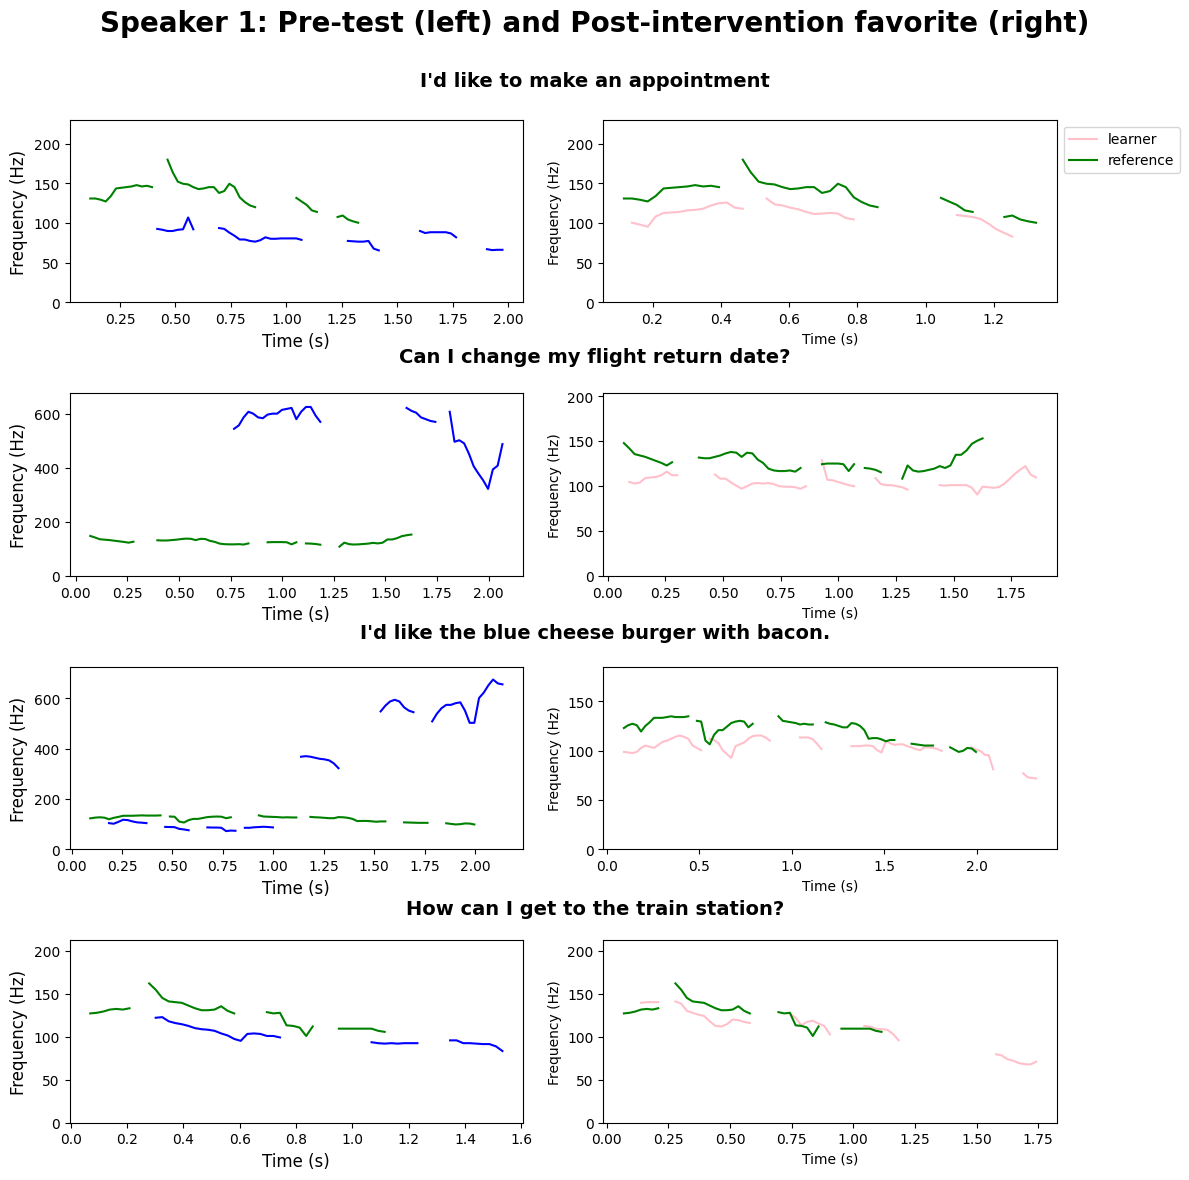

In [ ]:
fave_utts = {'fyi001':['1_1','2_2','3_1','4_3'], 'mkt000': ['1_2','2_3','3_3','4_2']}
baseline_utts = {'fyi001': ['1_0','2_0','3_0','4_0'], 'mkt000': ['1_0','2_0','3_0','4_0']}
row_titles = ["I'd like to make an appointment", "Can I change my flight return date?", "I'd like the blue cheese burger with bacon.", "How can I get to the train station?"]


#spkid = 'fyi001'
spkid = 'mkt000'
gender = 'male' if spkid[0] == 'm' else 'f'
user_dist[spkid] = []
user_corr[spkid] = []

if gender=='male':
  reffiledir = "/content/reference_audio_male_trimmed/"
else:
  reffiledir = "/content/reference_audio_female_trimmed/"

# set up plot
fig,axes = plt.subplots(4,2,figsize=(12,12))

for idx in range(1,5):
  print(f'Prompt {idx}')
  #########################
  ####### LOAD AUDIO ######
  ref_file = f'{reffiledir}r{idx}.wav'
  pre_filename = f'/content/saved_files/recording_{spkid}_{baseline_utts[spkid][idx-1]}.wav'
  post_filename = f'/content/saved_files/recording_{spkid}_{fave_utts[spkid][idx-1]}.wav'

  y_l1,sr_l = librosa.load(pre_filename)
  y_trimmed1 = trim_silence(y_l1)

  y_l2,sr_l = librosa.load(post_filename)
  y_trimmed2 = trim_silence(y_l2)

  # load reference audio files
  y_r,sr_r = librosa.load(ref_file)

  # get duration information from learner and reference
  dur1 = librosa.get_duration(y=y_trimmed1,sr=sr_l)
  dur3 = librosa.get_duration(y=y_trimmed2,sr=sr_l)
  dur2 = librosa.get_duration(y=y_r,sr=sr_r)
  dur_max_b = max(dur1,dur2)
  dur_max_f = max(dur2,dur3)

 #######################################
  ###### PITCH EXTRACTION (PEPLOs) ######
  # average male: 120: average female: 220
  f0b, voiced_flag, voiced_probs = librosa.pyin(y_trimmed1, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')) # trimmed recording
  f0f, voiced_flag, voiced_probs = librosa.pyin(y_trimmed2, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')) # trimmed recording
  f0_ref, vf_ref, vp_ref = librosa.pyin(y_r, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')) # reference recording

  # get utterance lengths to assign plot size (x limit)
  time1 = librosa.frames_to_time(np.arange(len(f0b)), sr=sr_l) # trimmed
  time3 = librosa.frames_to_time(np.arange(len(f0f)), sr=sr_l) # trimmed
  time2 = librosa.frames_to_time(np.arange(len(f0_ref)), sr=sr_r) # reference

  ###### SIGNAL DISTANCE COMPUTATION ######

  dist, corr = compare_signals(f0b,f0f,f0_ref)
  user_dist[spkid].append(dist)
  user_corr[spkid].append(corr)

  ###########################
  ###### PLOT CONTOURS ######
  # baseline
  ax = axes[idx-1][0]
  ax.plot(time1, f0b, color='b', label='learner')
  ax.plot(time2, f0_ref, color='g', label='reference')
  ax.set_xlabel('Time (s)', fontsize=12)
  ax.set_ylabel('Frequency (Hz)', fontsize=12)

  max_y_value = max(np.nanmax(f0b), np.nanmax(f0_ref)) # find max value of ref and learner pitch
  ax.set_ylim(0, max_y_value + 50)  # Set y-axis to start at 0 Hz and go to max from above

#  ax.set_title(f'Pre-test: {row_titles[idx-1]}',loc='center', fontsize=14, y=1.2)
  # favorite
  ax = axes[idx-1][1]
  ax.plot(time3, f0f, color='pink', label='learner')
  ax.plot(time2, f0_ref, color='g', label='reference')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequency (Hz)')

  max_y_value = max(np.nanmax(f0f), np.nanmax(f0_ref)) # find max value of ref and learner pitch
  ax.set_ylim(0, max_y_value + 50)  # Set y-axis to start at 0 Hz and go to max from above

#  ax.set_title(f'Pitch Contour {idx}')

  if(idx == 1):
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))

for row_idx, title in enumerate(row_titles):
    fig.text(0.5, 0.92 - 0.23 * row_idx, title, ha='center', va='center', fontsize=14, weight='bold')

#plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Make room for titles
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Speaker 1: Pre-test (left) and Post-intervention favorite (right)", fontsize=20, weight='bold')
savefilename = f'contours_{spkid}'
#plt.savefig(savefilename, transparent=True)
plt.show()


### Distance Plotting

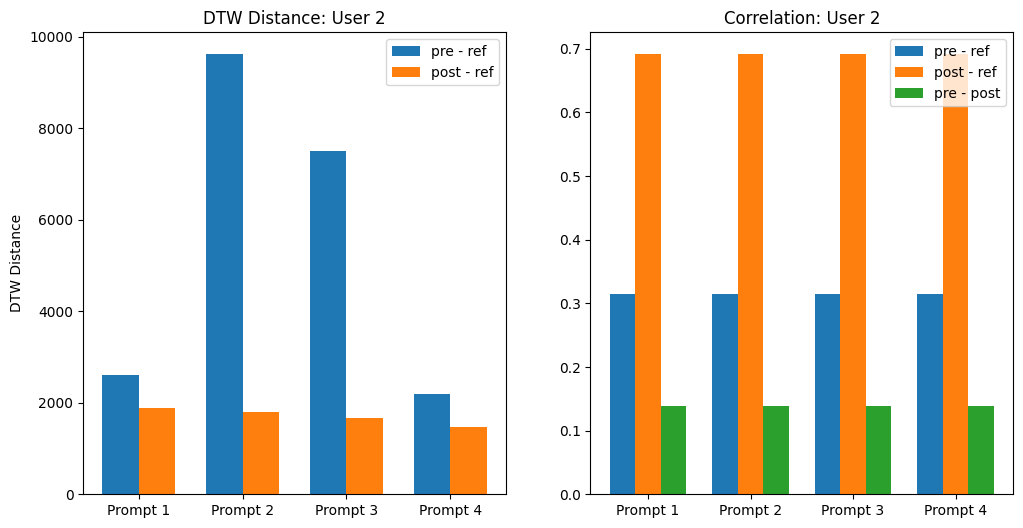

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
bar_labels = ["Prompt 1", "Prompt 2", "Prompt 3", "Prompt 4"]

dtw_pre = [dist[0][0] for dist in user_dist[spkid]]
dtw_post = [dist[0][1] for dist in user_dist[spkid]]
x = np.arange(1,5)
width=0.35

ax1.bar(x-width/2,dtw_pre,width,label='pre - ref')
ax1.bar(x+width/2,dtw_post,width,label='post - ref')
ax1.set_ylabel('DTW Distance')
#ax1.set_xlabel('DTW')
ax1.set_xticks(x)
ax1.set_xticklabels(bar_labels)
ax1.set_title(f'DTW Distance: User 2')
ax1.legend()

width = 0.25
corr_pre = corr[0][0]
corr_post = corr[0][1]
corr_pre_post = corr[0][2]

ax2.bar(x-width,corr_pre,width,label='pre - ref')
ax2.bar(x,corr_post,width,label='post - ref')
ax2.bar(x+width,corr_pre_post,width,label='pre - post')
ax2.set_xticks(x)
ax2.set_xticklabels(bar_labels)
ax2.set_title('Correlation: User 2')
ax2.legend()
plt.savefig(f'distances_{spkid}')
plt.show()

### Distance Metrics

In [ ]:
!pip install fastdtw
from fastdtw import fastdtw
#from scipy.spatial.distance import euclidean

def align_vectors(v1, v2):
  distance,path = fastdtw(v1, v2, dist=2) # there is a mismatch in the scipy/fastdtw def of euclidean and this approximates w/o error
  aligned_v1 = np.asarray([v1[i] for i,_ in path])
  aligned_v2 = np.asarray([v2[j] for _,j in path])
  print(aligned_v1)
  print(aligned_v2)
  return(aligned_v1,aligned_v2)


vector1 = np.array([1, 2, 3, 4, 5])
vector2 = np.array([2, 3, 4])
ref_aligned, lrn_aligned = align_vectors(vector1,vector2)
ref_lrn_distance = np.mean((ref_aligned - lrn_aligned) ** 2)
print(ref_lrn_distance)


[1 2 3 4 5]
[2 2 3 4 4]
0.4


## Maybe Helpful


In [ ]:
# different ways to read and write audio
!sudo apt-get install portaudio19-dev
!pip install sounddevice
import sounddevice as sd
import soundfile as sf

duration = 5  # seconds
fs = 44100

myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
sf.write('my_audio.wav', myrecording, fs)  # Save as WAV file

In [ ]:
# using MFA align_one instead of batch align
#  !source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa align_one --clean -j 1 /content/mfa/sourcefiles/f1.wav /content/mfa/sourcefiles/f1.txt promptlex.txt english.zip /content/mfa/aligned
#  !source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa align_one --clean --overwrite -j 1 {learner_wave_file} {learner_text_file} promptlex.txt english.zip /content/mfa/aligned
#  align_one arguments: SOUND_FILE_PATH TEXT_FILE_PATH DICTIONARY_PATH ACOUSTIC_MODEL_PATH OUTPUT_PATH


In [ ]:
# Things that might fix the problem of the record button stopping working:
import time

camera.close()
del recorder
gc.collect()
time.sleep(1)  # Brief delay to ensure resources are freed
camera.active=True
camera = CameraStream(constraints={'audio': True,'video':False})  # Recreate CameraStream
recorder = AudioRecorder(stream=camera)
display(recorder)